# Scaling for the ACCESS-OM3 Regional 4km Configuration

## Overview
This notebook describes the setup and steps for conducting scaling analyses of the ACCESS-OM3 regional 4km configuration (panan 4km). TThe goal is to evaluate model performance across different processor layouts for all NUOPC run phases. The workflow involves three main tools,
- [experiment-generator](https://github.com/ACCESS-NRI/access-experiment-generator) - generates branch configurations for scaling experiments,
- [experiment-runner](https://github.com/ACCESS-NRI/access-experiment-runner) - executes the generated experiments,
- [esmf-trace](https://github.com/ACCESS-NRI/esmf-trace) - postprocesses runtime profiling output to analyse scaling and efficiency.


## Model configuration
### Repo
The base configuration used in this analysis is:
> https://github.com/claireyung/access-om3-configs @`dev-MC_4km_jra_ryf+regionalpanan` @`c6ab817`

## Experiment generation 

### [experiment-generator](https://github.com/ACCESS-NRI/access-experiment-generator)

Below is the yaml plan to generate experiment branches using experiment-generator,
```yaml
model_type: access-om3
repository_url: git@github.com:claireyung/access-om3-configs.git
start_point: "c6ab817" # Control commit hash for new branches
test_path: "." # All control and perturbation experiment repositories will be created here; can be relative, absolute or ~ (user-defined)
repository_directory: panan_4km_only # Local directory name for the central repository (user-defined)
control_branch_name: ctrl
Control_Experiment:

Perturbation_Experiment:
  Parameter_block_panan_4km_all1:
    branches: ['panan_4km_only_1', 'panan_4km_only_2', 'panan_4km_only_3', 'panan_4km_only_4', 'panan_4km_only_5', 'panan_4km_only_6', 'panan_4km_only_7', 'panan_4km_only_8', 'panan_4km_only_9', 'panan_4km_only_10', 'panan_4km_only_11']

    MOM_input:
      RESTART_CHECKSUMS_REQUIRED: false
      AUTO_IO_LAYOUT_FAC: REMOVE

    config.yaml:
      project: REMOVE
      shortpath: REMOVE

      env:
        ESMF_RUNTIME_PROFILE: "on"
        ESMF_RUNTIME_TRACE: "on"
        ESMF_RUNTIME_TRACE_PETLIST: ['0 104', '0 520', '0 936', '0 1352', '0 1768', '0 2184', '0 2600', '0 3016', '0 3432', '0 3848', '0 4264']
        ESMF_RUNTIME_PROFILE_OUTPUT: "SUMMARY"

      ncpus: [156, 624, 1092, 1560, 2028, 2496, 2964, 3432, 3900, 4368, 4836]
      mem: ['1000GB', '3000GB', '5500GB', '7500GB', '10000GB', '12000GB', '14500GB', '16500GB', '19000GB', '21000GB', '23500GB']
      walltime: ['10:00:00', '5:00:00', '5:00:00', '5:00:00', '5:00:00', '5:00:00', '5:00:00', '5:00:00', '5:00:00', '5:00:00', '5:00:00']


      metadata:
        enable: true

      # repeat: True

    nuopc.runconfig:
      PELAYOUT_attributes:
        atm_ntasks: [52, 104, 156, 208, 260, 312, 364, 416, 468, 520, 572]
        cpl_ntasks: [52, 104, 156, 208, 260, 312, 364, 416, 468, 520, 572]
        ice_ntasks: [52, 104, 156, 208, 260, 312, 364, 416, 468, 520, 572]
        ocn_ntasks: [104, 520, 936, 1352, 1768, 2184, 2600, 3016, 3432, 3848, 4264]
        ocn_rootpe: [52, 104, 156, 208, 260, 312, 364, 416, 468, 520, 572]
        rof_ntasks: [52, 104, 156, 208, 260, 312, 364, 416, 468, 520, 572]

      CLOCK_attributes:
        restart_n: 2
        restart_option: ndays
        stop_n: 2
        stop_option: ndays

```
This setup produces 11 perturbation branches under `panan_4km_only/`, each representing an experiment with increasing processor counts.

Because profiling is performed with [`esmf-trace`](https://github.com/ACCESS-NRI/esmf-trace), each experiment simulates only two model days, which is sufficient to capture detailed performance characteristics while keeping costs low.

For this configuration with a coupling timestep of 600 s (10 minutes), there are 572 run-phase steps per run. This duration provides stable performance statistics while avoiding unnecessary computational overhead. This is ideal for high-res experiments such as this 4 km regional setup.

### Runtime tracing configuration
#### Profiling with ESMF runtime
ESMF provides built-in profiling and tracing capabilities. When `ESMF_RUNTIME_PROFILE` and `ESMF_RUNTIME_TRACE` are enabled, the framework collects timing information for all major component phases:
- Init1
- RunPhase1
- FinalizePhase1

These timings can be written as binary trace streams and summary text reports (for quick inspection). In this analysis, both formats are enabled.

To limit data volume while preserving accuracy, only the first [PET (persistent execution thread)](https://earthsystemmodeling.org/docs/nightly/develop/ESMF_usrdoc/node8.html) of each component is traced. A PET in ESMF corresponds to a task or MPI rank. For the panan-4km setup, only selected PETs are traced (e.g. PET 0 for the sequential components and PET 104 for the concurrently running ocean component). This approach captures the most computationally active processors while avoiding large unnecessary trace outputs.

Below is the corresponding environment configuration:
```yaml
      env:
        ESMF_RUNTIME_PROFILE: "on"
        ESMF_RUNTIME_TRACE: "on"
        ESMF_RUNTIME_TRACE_PETLIST: ['0 104', '0 520', '0 936', '0 1352', '0 1768', '0 2184', '0 2600', '0 3016', '0 3432', '0 3848', '0 4264']
        ESMF_RUNTIME_PROFILE_OUTPUT: "SUMMARY"
```

- In `panan_4km_only_1`, the ICE, ATM, ROF, and MED components share the first 52 cores and run sequentially.
- The OCN component runs concurrently on 104 cores.
- PET 0 (for sequential components) and PET 104 (first ocean PET) are traced.

### Running Experiments with [experiment-runner](https://github.com/ACCESS-NRI/access-experiment-runner)
The experiments are executed using the ACCESS Experiment-Runner. Below is the yaml plan,
```yaml
test_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3 # All control and perturbation experiment repositories.
repository_directory: panan_4km_only # Local directory name for the central repository, where the running_branches are forked from.
keep_uuid: True
# ================= 1 =================
running_branches: ['panan_4km_only_1', 'panan_4km_only_2', 'panan_4km_only_3', 'panan_4km_only_4', 'panan_4km_only_5', 'panan_4km_only_6', 'panan_4km_only_7', 'panan_4km_only_8', 'panan_4km_only_9', 'panan_4km_only_10', 'panan_4km_only_11']

nruns: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

startfrom_restart: ['cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold']
```
Each experiment runs once and starts from a cold start, ensuring reproducibility and independent scaling measurements.

## Postprocessing trace timeseries

### ESMF traceout
After each run we are having a `traceout` directory for each configuration, such as under `panan_4km_only_1/panan_4km_only/archive/output/traceout`,
```bash
esmf_stream_0000  esmf_stream_0104  metadata
```
where,
 - `esmf_stream_xxxx` – binary trace streams, one per PET traced.
 - `metadata` – describes the trace context (e.g. PET IDs, timing units, region names) so the streams can be interpreted together via the Common Trace Format (CTF).

### [`esmf-trace`](https://github.com/ACCESS-NRI/esmf-trace)
esmf-trace parses and processes the `ESMF` trace files to produce timeseries and summary statistics for each component. It provides two main commands:

1. Generate json timeseries

`esmf-trace run-from-yaml --config run-config.yaml`

2. Generate summarised statistics

`esmf-trace post-summary-from-yaml --config run-config.yaml`

The resulting summaries are analogous to FMS timing output but are per-timestep rather than integrated over the entire run. One example is,

| name | hits | tmin | tmax | tavg | tmedian | tstd | pemin | pemax |
|------|------|------|------|------|----------|------|-------|-------|
| postprocessing_panan_4km_only_1/output000/[ESMF]/[ensemble] Init 1/[ESM0001] IPDv02p5/[MED] IPDv03p7 | 2 | 0.773399 | 95.048981 | 47.911190 | 47.911190 | 66.662903 | 0 | 0 |
| postprocessing_panan_4km_only_1/output000/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ATM] RunPhase1 | 288 | 0.018944 | 0.195784 | 0.038370 | 0.028390 | 0.028717 | 0 | 0 |

#### Flame graph
`esmf-trace` can also generate flame graphs, which visualize time spent in nested calls. The wider a block appears, the more time that call consumed hence it is a valuable guide for identifying computational hotspots and optimisation targets.

---

‼️ Note:
The generation of json timeseries and postprocessing summaries is currently **only** supported via command-line execution, **not directly** within Jupyter notebooks.

Once the outputs are created, they can be saved into pandas as `.parquet` files for further statistical and scaling analysis. The following notebook starts from this `.parquet` file.

# Running this notebook on Gadi
These steps set up esmf-trace and hook your virtual environment into Gadi Jupyter session.

### Clone the repo
```bash
git clone https://github.com/ACCESS-NRI/esmf-trace
cd esmf-trace
```

### Create & activate a virtual environment
```
python -m venv .venv
. .venv/bin/activate
```

### Load required modules (for babeltrace2)
`babeltrace2` has been installed under `access-nri/model-tools`, hence you can load it directly from,
```
module use /g/data/vk83/modules && module load model-tools/babeltrace2/2.1.2
source .venv/bin/activate
```

### Install esmf-trace and check installation status
```
pip install -r requirements.txt
pip install -e .
esmf-trace --help
```

Or for convenience you can simply run the setup script,
```
./setup.sh
module use /g/data/vk83/modules && module load model-tools/babeltrace2/2.1.2
source .venv/bin/activate
esmf-trace --help
```

### Using the venv in ARE
When launching a notebook on Gadi, click `Show advanced settings`,

Set `Module directories` to `/g/data/vk83/modules`

Set `Python or Conda virtual environment base` to your venv path such as `path/to/esmf-trace/.venv`

In [1]:
from access.esmf_trace.tmp_yaml_parser import read_yaml, write_yaml
from access.esmf_trace.postprocess import _norm_model_component
import pandas as pd
from pathlib import Path

import re
import numpy as np
import matplotlib.pyplot as plt

## Generate `run-config.yaml` for `run-from-yaml`
Before extracting the timing timeseries, we first need to create a configuration file named for example, `run-config.yaml`. This file tells `esmf-trace` what to read, which components or phases to extract, and where to output the processed data.

The helper function below automatically generates a properly formatted `run-config.yaml`, which will later be used to produce a json timeseries file by the following through the command line,

```
esmf-trace run-from-yaml --config run-config.yaml
```

In [2]:
DEFAULTS = {
    "stream_prefix": "esmf_stream",
    # "max_workers": 48, # can be auto-determined based on the applied cores
    "xaxis_datetime": False,
    "separate_plots": False,
    "cmap": "tab10",
    "renderer": "browser",
    "show_html": False,
}

def gen_run_config(
    *,
    post_base_path: str,
    model_component: str,
    base_prefix: str,
    count: int,
    list_pets: list[str],
    list_exact_path: list[str],
):
    runs = []
    for i in range(1, count + 1):
        name = f"{base_prefix}_{i}"
        r = {
            "base_prefix": name,
            "pets": list_pets[i-1],
        }

        r["exact_path"] = list_exact_path[i-1]

        runs.append(r)

    return {
        "default_settings": {
            "post_base_path": post_base_path,
            "model_component": model_component,
            "max_workers": 12, # default workers dont run on login node. 
            **DEFAULTS
        },
        "runs": runs,
    }

## Generate `postprocessing-config.yaml` for `post-summary-from-yaml`
After creating json timeseries with `run-from-yaml`, we postprocess them into concise and timestep-aware summary tables (similar in spirit to FMS timing output).
This helper function helps generate a `postprocessing-config.yaml` that tells `esmf-trace` which inputs to read, how to group/phases to aggregate, and where to write the summaries.

```
esmf-trace post-summary-from-yaml --config postprocessing-config.yaml
```


In [3]:
DEFAULTS = {
    "stream_prefix": "esmf_stream",
    "timeseries_suffix": "_timeseries.json",
}

def gen_postprocessing_config(
    *,
    post_prefix: str = "postprocessing",
    base_prefix: str,
    model_component: str | list[str],
    post_base_path: str,
    count: int,
    save_json_path: str,
    list_pets: list[str],
    stats_start_index: int,
    stats_end_index: int,
):
    runs = []
    for i in range(1, count + 1):
        name = f"{post_prefix}_{base_prefix}_{i}"
        r = {
            "name": name,
            "pets": list_pets[i-1],
        }
        runs.append(r)

    return {
        "default_settings": {
            "post_base_path": post_base_path,
            "model_component": model_component,
            "save_json_path": save_json_path,
            "stats_start_index": stats_start_index,
            "stats_end_index": stats_end_index,
            **DEFAULTS
        },
        "runs": runs,
    }

## plot for scaling

In [4]:
plt.rcParams.update({
    "font.size": 15,
    "axes.titlesize": 15,
    "axes.labelsize": 15,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
})

def _extract_component_from_name(base_prefix, name):
    s = str(name)
    if "/output" in s or "/combine/" in s:
        after = s.split("/", 1)[1]
        parts = after.split("/", 1)
        return parts[1] if len(parts) > 1 else None
    return None

def _filter_by_components_index(stats_df, base_prefix, comps):
    if not comps:
        return stats_df
    wanted = {c.strip() for c in comps}
    idx = stats_df.index.to_series()
    keep = idx.map(lambda nm: (_extract_component_from_name(base_prefix, str(nm)) or "").strip() in wanted)
    return stats_df[keep]

def _parse_name_index(base_prefix, name):
    s = str(name)
    if "/output" in s:
        after = s.split("/", 1)[1]
        output_name = after.split("/", 1)[0]
    elif "/combine/" in s:
        output_name = "combine"
    else:
        output_name = None
    m = re.search(rf"{re.escape(base_prefix)}_(\d+)", s)
    if not m:
        head = s.split("/", 1)[0]
        m = re.search(r"_(\d+)(?:$|[_/])", head)
    case_id = int(m.group(1)) if m else None
    return case_id, output_name

def _build_pivot(stats_df, base_prefix, cores, ycol, outputs, aggfunc="mean"):
    df = stats_df.copy()
    parsed = df.index.to_series().map(lambda s: _parse_name_index(base_prefix, str(s)))
    df["__case_id"] = parsed.map(lambda t: t[0])
    df["__output_name"] = parsed.map(lambda t: t[1])
    df = df[df["__output_name"].isin(outputs)].copy()

    order = df["__case_id"].copy()
    df["__order"] = order.astype(int)
    df = df.sort_values(["__order", "__output_name"], kind="mergesort")

    piv = df.pivot_table(index="__order", columns="__output_name", values=ycol, aggfunc=aggfunc).sort_index()
    for col in outputs:
        if col not in piv.columns:
            piv[col] = np.nan
    piv = piv.loc[:, list(outputs)]

    piv.index = pd.Index(cores, name="cores")
    x = piv.index.to_numpy(dtype=float)
    return piv, x

def _style_axes_with_top_index(ax, x, logx=False, logy=False, xlabel="Number of CPUs", top_label="Index", rotate=45):
    if logx:
        ax.set_xscale("log")
    if logy:
        ax.set_yscale("log")
    ax.set_xticks(x)
    ax.set_xticklabels([str(int(v)) for v in x], rotation=rotate)
    ax.set_xlabel(xlabel)
    ax2 = ax.twiny()
    if logx:
        ax2.set_xscale("log")
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(x)
    ax2.set_xticklabels([str(i) for i in range(len(x))], rotation=rotate)
    ax2.set_xlabel(top_label)
    return ax2

def plot_scaling(stats_df: pd.DataFrame,
                 base_prefix: str,
                 ycol: str = "tmedian",
                 outputs: tuple[str, ...] = ("combine",),
                 output_for_ideal: str = "combine",
                 ideal_ref_index: int = 1,
                 title: str = "Strong scaling",
                 ylabel: str | None = None,
                 figsize: tuple[int, int] = (20, 6),
                 loglog: bool = True,
                 model_component: str | list[str] | None = None,
                 subplot_by_component: bool = False,
                 subplot_nrow: int | None = None,
                 subplot_ncol: int | None = None,
                 ylim=None,
                 new_vars: dict[str, list[str]] | None = None,
                 cores_per_component: dict[str, list[int]] | None = None,
                 ):
    if not cores_per_component:
        raise ValueError("`cores_per_component` is required and cannot be empty.")

    comps = []
    comp_labels = []

    mc = _norm_model_component(model_component)
    if mc:
        comps.extend(mc)
        comp_labels.extend([c.split("/")[-1] for c in mc])

    if new_vars:
        for new_name, parts in new_vars.items():
            parts_norm = _norm_model_component(parts) or []
            if not parts_norm:
                raise ValueError(f"-- new_var '{new_name}' has no components!")
            comps.append(parts_norm)
            comp_labels.append(new_name)

    if not comps:
        comps = [None]
        comp_labels = ["(all)"]

    # subplot setup
    if subplot_by_component and len(comps) > 1:
        if subplot_nrow is None or subplot_ncol is None:
            subplot_ncol = 2
            subplot_nrow = int(np.ceil(len(comps) / subplot_ncol))
        fig, axes = plt.subplots(subplot_nrow, subplot_ncol, figsize=figsize)
        axes = np.array(axes).flatten()
        for extra_ax in axes[len(comps):]:
            extra_ax.remove()
    else:
        fig, ax = plt.subplots(figsize=figsize)
        axes = np.array([ax])

    pivot_blocks, keys = [], []
    idx_series = stats_df.index.to_series().astype(str)

    label_keys = []
    cores_map = {}
    for comp, short_lbl in zip(comps, comp_labels):
        label_key = short_lbl if comp is not None else "(all)"
        if label_key not in cores_per_component:
            if comp is None:
                raise KeyError("No cores specified for component '(all)' in cores_per_component.")
        else:
            cores_map[label_key] = np.asarray(cores_per_component[label_key], dtype=float)
            label_keys.append(label_key)

    if not subplot_by_component or len(comps) == 1:
        # union for single-panel x-axis
        x_union = np.array(sorted(set(np.concatenate([cores_map[k] for k in label_keys]))), dtype=float)

    for i, (comp, short_lbl) in enumerate(zip(comps, comp_labels)):
        ax = axes[i if i < len(axes) else -1]

        # cores for this component
        label_key = short_lbl if comp is not None else "(all)"
        if label_key not in cores_per_component:
            raise KeyError(f"No cores specified for component '{label_key}' in cores_per_component.")
        cores_use = np.asarray(cores_per_component[label_key], dtype=float)

        if comp is None:
            df_use = stats_df
            aggfunc = "mean"
        elif isinstance(comp, (list, tuple, set)):
            df_use = _filter_by_components_index(stats_df, base_prefix, list(comp))
            aggfunc = "sum"
        else:
            df_use = _filter_by_components_index(stats_df, base_prefix, [short_lbl])
            if df_use.empty:
                df_use = stats_df[idx_series.str.contains(re.escape(short_lbl), regex=True)]
            aggfunc = "mean"

        if df_use.empty:
            print(f"-- No data found for component '{short_lbl}'. Skipping.")
            continue

        pivot, _ = _build_pivot(df_use, base_prefix, cores_use, ycol, outputs, aggfunc=aggfunc)

        if ("combine" in outputs) and ("combine" not in pivot.columns):
            present_output_cols = [c for c in pivot.columns if isinstance(c, str) and c.startswith("output")]
            if present_output_cols:
                pivot["combine"] = pivot[present_output_cols].sum(axis=1, skipna=True)

        # plot outputs
        for out in outputs:
            if out not in pivot.columns:
                continue
            y = pivot[out].to_numpy(dtype=float)
            mask = np.isfinite(cores_use) & np.isfinite(y)
            if loglog:
                mask &= (cores_use > 0) & (y > 0)
            if not mask.any():
                continue

            x_plot, y_plot = cores_use[mask], y[mask]
            label = short_lbl if not subplot_by_component or len(comps) == 1 else out
            line, = ax.plot(x_plot, y_plot, "o-", linewidth=1.2, markersize=3, label=label)

            # ideal line
            if out == output_for_ideal and (0 <= ideal_ref_index < len(x_plot)):
                y0, x0 = y_plot[ideal_ref_index], x_plot[ideal_ref_index]
                ax.plot(x_plot, y0 * (x0 / x_plot), "--", linewidth=1.0,
                        color=line.get_color(),
                        label=(f"{label} (ideal)" if not subplot_by_component or len(comps) == 1 else "ideal"))

        if loglog:
            ax.set_xscale("log")
            ax.set_yscale("log")

        if subplot_by_component and len(comps) > 1:
            _ = _style_axes_with_top_index(ax, cores_use, logx=loglog, logy=loglog,
                                           xlabel="Number of CPUs", top_label="Index", rotate=45)
            ax.set_title(short_lbl)

        pivot_blocks.append(pivot)
        keys.append(label_key)

        if ylim is not None:
            if isinstance(ylim, tuple):
                ax.set_ylim(*ylim)
            elif isinstance(ylim, dict) and label_key in ylim:
                ax.set_ylim(*ylim[label_key])

        if not (subplot_by_component and len(comps) > 1):
            ax = axes[0]
            if loglog:
                ax.set_xscale("log")
                ax.set_yscale("log")
            ax.set_xticks(x_union)
            ax.set_xticklabels([str(int(v)) for v in x_union], rotation=45)
            ax.set_xlabel("Number of CPUs")

    axes[0].set_ylabel(ylabel or ycol)
    if not (subplot_by_component and len(comps) > 1):
        axes[0].set_title(title)
    else:
        fig.suptitle(title, y=0.98)

    for ax in axes:
        h, l = ax.get_legend_handles_labels()
        if h:
            uniq = dict(zip(l, h))
            ax.legend(uniq.values(), uniq.keys(), ncol=2)
            ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

    pivot_summary = pd.concat(pivot_blocks, axis=1, keys=keys).sort_index()
    pivot_summary.index.name = "cores"
    return pivot_summary

def plot_speedup(stats_df: pd.DataFrame,
                 base_prefix: str,
                 cores: list[int],
                 ycol: str = "tmedian",
                 outputs: tuple[str, ...] = ("combine",),
                 output_for_ideal: str = "combine",
                 ideal_ref_index: int = 1,
                 title: str = "Speedup",
                 ylabel: str | None = "Speedup",
                 figsize: tuple[int, int] = (20, 6),
                 loglog: bool = True,
                 model_component: str | list[str] | None = None,
                 subplot_by_component: bool = False,
                 subplot_nrow: int | None = None,
                 subplot_ncol: int | None = None,
                 ylim=None,
                 new_vars: dict[str, list[str]] | None = None,
                 ):
    """
    Speedup S(n) = T_ref / T(n).
    Ideal: S_ideal(n) = n / n_ref.
    """

    comps = []
    comp_labels = []

    mc = _norm_model_component(model_component)
    if mc:
        # explicit model components
        comps.extend(mc)
        comp_labels.extend([c.split("/")[-1] for c in mc])

    if new_vars:
        for new_name, parts in new_vars.items():
            parts_norm = _norm_model_component(parts) or []
            if not parts_norm:
                raise ValueError(f"-- new_var '{new_name}' has no components!")
            # keep the group of parts together under one label
            comps.append(parts_norm)
            comp_labels.append(new_name)
    
    # If nothing specified at all, fall back to (all)
    if not comps:
        comps = [None]
        comp_labels = ["(all)"]

    # figure/axes
    if subplot_by_component and len(comps) > 1:
        if subplot_nrow is None or subplot_ncol is None:
            subplot_ncol = 2
            subplot_nrow = int(np.ceil(len(comps) / subplot_ncol))
        fig, axes = plt.subplots(subplot_nrow, subplot_ncol, figsize=(figsize[0], figsize[1]))
        axes = np.array(axes).flatten()
        for extra_ax in axes[len(comps):]:
            extra_ax.remove()
    else:
        fig, ax = plt.subplots(figsize=figsize)
        axes = np.array([ax])

    x_all = np.asarray(cores, dtype=float)
    metric_blocks, keys = [], []

    for i, (comp, short_lbl) in enumerate(zip(comps, comp_labels)):
        ax = axes[i if i < len(axes) else -1]
        if comp is None:
            df_use = stats_df
        elif isinstance(comp, (list, tuple, set)):
            df_use = _filter_by_components_index(stats_df, base_prefix, list(comp))
        else:
            df_use = _filter_by_components_index(stats_df, base_prefix, [comp])
        if isinstance(df_use, pd.DataFrame) and df_use.empty:
            print(f"-- No data found for model_component='{comp}'. Skipping.")
            continue

        pivot, _ = _build_pivot(df_use, base_prefix, cores, ycol, outputs, aggfunc="mean")

        if ("combine" in outputs) and ("combine" not in pivot.columns):
            req = [o for o in outputs if str(o).startswith("output")]
            piv_o, _ = _build_pivot(df_use, base_prefix, cores, ycol, tuple(req), aggfunc="mean")
            present = [c for c in req if c in piv_o.columns]
            if present:
                pivot["combine"] = piv_o[present].mean(axis=1, skipna=True)

        metric_df = pd.DataFrame(index=pd.Index(cores, name="cores"),
                                 columns=list(outputs), dtype=float)
        # plot
        for out in outputs:
            if out not in pivot.columns:
                continue
            t = pivot[out].to_numpy(dtype=float)  # times
            if loglog:
                mask = np.isfinite(x_all) & (x_all > 0) & np.isfinite(t) & (t > 0)
            else:
                mask = np.isfinite(x_all) & np.isfinite(t)
            if not mask.any():
                continue

            idxs = np.where(mask)[0]
            x_plot, t_plot = x_all[mask], t[mask]
            if not (0 <= ideal_ref_index < len(t_plot)):
                continue
            t_ref = t_plot[ideal_ref_index]
            n_ref = x_plot[ideal_ref_index]

            y_speedup = t_ref / t_plot  # S(n)

            metric_df.iloc[idxs, metric_df.columns.get_loc(out)] = y_speedup

            label = (short_lbl if not subplot_by_component or len(comps) == 1 else out)
            line, = ax.plot(x_plot, y_speedup, "o-", linewidth=1.2, markersize=3, label=label)

            # ideal line: n / n_ref
            ax.plot(x_plot, x_plot / n_ref, "--", linewidth=1.0, color=line.get_color(),
                    label=(f"{label} (ideal)" if not subplot_by_component or len(comps) == 1 else "ideal"))

        if loglog:
            ax.set_xscale("log"); ax.set_yscale("log")
        _ = _style_axes_with_top_index(ax, x_all, logx=loglog, logy=loglog, xlabel="Number of CPUs", top_label="Index", rotate=45)
        if subplot_by_component and len(comps) > 1:
            ax.set_title(short_lbl)

        metric_blocks.append(metric_df)
        keys.append(short_lbl if (comp is not None) else "(all)")

        if ylim is not None:
            if isinstance(ylim, tuple):
                ax.set_ylim(*ylim)
            elif isinstance(ylim, dict):
                key = short_lbl if short_lbl in ylim else "(all)"
                if key in ylim:
                    ax.set_ylim(*ylim[key])

    axes[0].set_ylabel(ylabel or "Speedup (×)")
    if not (subplot_by_component and len(comps) > 1):
        axes[0].set_title(title)
    else:
        fig.suptitle(title, y=0.98)

    for ax in axes:
        h, l = ax.get_legend_handles_labels()
        if h:
            uniq = dict(zip(l, h))
            ax.legend(uniq.values(), uniq.keys(), ncol=2)
        ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

    speedup_summary = pd.concat(metric_blocks, axis=1, keys=keys)
    return speedup_summary

def plot_efficiency(stats_df: pd.DataFrame,
                    base_prefix: str,
                    cores: list[int],
                    ycol: str = "tmedian",
                    outputs: tuple[str, ...] = ("combine",),
                    output_for_ideal: str = "combine",
                    ideal_ref_index: int = 1,
                    title: str = "Parallel efficiency",
                    ylabel: str | None = "Efficiency",
                    figsize: tuple[int, int] = (20, 6),
                    loglog: bool = False,
                    model_component: str | list[str] | None = None,
                    subplot_by_component: bool = False,
                    subplot_nrow: int | None = None,
                    subplot_ncol: int | None = None,
                    ylim=None,
                    new_vars: dict[str, list[str]] | None = None,
                    ):
    """
    Efficiency eta(n) = S(n) * (n_ref / n) = (T_ref * n_ref) / (T(n) * n).
    Ideal: eta_ideal = 1 (flat line).
    """

    comps = []
    comp_labels = []

    mc = _norm_model_component(model_component)
    if mc:
        # explicit model components
        comps.extend(mc)
        comp_labels.extend([c.split("/")[-1] for c in mc])

    if new_vars:
        for new_name, parts in new_vars.items():
            parts_norm = _norm_model_component(parts) or []
            if not parts_norm:
                raise ValueError(f"-- new_var '{new_name}' has no components!")
            # keep the group of parts together under one label
            comps.append(parts_norm)
            comp_labels.append(new_name)
    
    # If nothing specified at all, fall back to (all)
    if not comps:
        comps = [None]
        comp_labels = ["(all)"]

    if subplot_by_component and len(comps) > 1:
        if subplot_nrow is None or subplot_ncol is None:
            subplot_ncol = 2
            subplot_nrow = int(np.ceil(len(comps) / subplot_ncol))
        fig, axes = plt.subplots(subplot_nrow, subplot_ncol, figsize=(figsize[0], figsize[1]))
        axes = np.array(axes).flatten()
        for extra_ax in axes[len(comps):]:
            extra_ax.remove()
    else:
        fig, ax = plt.subplots(figsize=figsize)
        axes = np.array([ax])

    x_all = np.asarray(cores, dtype=float)
    metric_blocks, keys = [], []

    for i, (comp, short_lbl) in enumerate(zip(comps, comp_labels)):
        ax = axes[i if i < len(axes) else -1]
        if comp is None:
            df_use = stats_df
        elif isinstance(comp, (list, tuple, set)):
            df_use = _filter_by_components_index(stats_df, base_prefix, list(comp))
        else:
            df_use = _filter_by_components_index(stats_df, base_prefix, [comp])
        if isinstance(df_use, pd.DataFrame) and df_use.empty:
            print(f"-- No data found for model_component='{comp}'. Skipping.")
            continue

        pivot, _ = _build_pivot(df_use, base_prefix, cores, ycol, outputs, aggfunc="mean")

        if ("combine" in outputs) and ("combine" not in pivot.columns):
            req = [o for o in outputs if str(o).startswith("output")]
            piv_o, _ = _build_pivot(df_use, base_prefix, cores, ycol, tuple(req), aggfunc="mean")
            present = [c for c in req if c in piv_o.columns]
            if present:
                pivot["combine"] = piv_o[present].mean(axis=1, skipna=True)

        metric_df = pd.DataFrame(index=pd.Index(cores, name="cores"),
                                 columns=list(outputs), dtype=float)

        for out in outputs:
            if out not in pivot.columns:
                continue
            t = pivot[out].to_numpy(dtype=float)

            if loglog:
                mask = np.isfinite(x_all) & (x_all > 0) & np.isfinite(t) & (t > 0)
            else:
                mask = np.isfinite(x_all) & np.isfinite(t)
            if not mask.any():
                continue

            idxs = np.where(mask)[0]
            x_plot, t_plot = x_all[mask], t[mask]
            if not (0 <= ideal_ref_index < len(t_plot)):
                continue
            t_ref = t_plot[ideal_ref_index]
            n_ref = x_plot[ideal_ref_index]

            eta = (t_ref * n_ref) / (t_plot * x_plot)

            metric_df.iloc[idxs, metric_df.columns.get_loc(out)] = eta

            label = (short_lbl if not subplot_by_component or len(comps) == 1 else out)
            line, = ax.plot(x_plot, eta, "o-", linewidth=1.2, markersize=3, label=label)

            ax.axhline(1.0, linestyle="--", linewidth=1.0, color=line.get_color(),
                       label=(f"{label} (ideal)" if not subplot_by_component or len(comps) == 1 else "ideal"))

        if loglog:
            ax.set_xscale("log"); ax.set_yscale("log")
        _ = _style_axes_with_top_index(ax, x_all, logx=loglog, logy=loglog, xlabel="Number of CPUs", top_label="Index", rotate=45)
        if subplot_by_component and len(comps) > 1:
            ax.set_title(short_lbl)

        metric_blocks.append(metric_df)
        keys.append(short_lbl if (comp is not None) else "(all)")

        if ylim is not None:
            if isinstance(ylim, tuple):
                ax.set_ylim(*ylim)
            elif isinstance(ylim, dict):
                key = short_lbl if short_lbl in ylim else "(all)"
                if key in ylim:
                    ax.set_ylim(*ylim[key])

    axes[0].set_ylabel(ylabel or "Efficiency")
    if not (subplot_by_component and len(comps) > 1):
        axes[0].set_title(title)
    else:
        fig.suptitle(title, y=0.98)

    for ax in axes:
        h, l = ax.get_legend_handles_labels()
        if h:
            uniq = dict(zip(l, h))
            ax.legend(uniq.values(), uniq.keys(), ncol=2)
        ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

    efficiency_summary = pd.concat(metric_blocks, axis=1, keys=keys)
    return efficiency_summary

## Total runtime scaling, speedup and efficiency

Since the OCN component runs concurrently with other components, the total runphase scaling is evaluated by taking the median walltime per timestep for the combined OCN component and MED-to-OCN coupling (including communication and synchronisation). The runtime scaling, speedup, and efficiency are then computed based on these values.

## Generate `run-config.yaml` for the panan-4km config

In [5]:
model_component = (
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1,"
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1"
)

suffix = "test_all_comp_ocn_sum_runphase"
count=11
base_prefix="panan_4km_only"
branch="panan_4km_only"
pets=['104', '520', '936', '1352', '1768', '2184', '2600', '3016', '3432', '3848', '4264']
list_pets = [p.replace(' ', ',') for p in pets]

list_exact_path = [f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/{base_prefix}_{i}/{branch}/archive" for i in range(1,count+1)]
post_base_path = f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/{base_prefix}_{suffix}"

run_config_med_dict = gen_run_config(
    post_base_path=post_base_path,
    model_component=model_component,
    base_prefix=base_prefix,
    count=count,
    list_pets=list_pets,
    list_exact_path=list_exact_path
)

run_config_med_path = f"/g/data/tm70/ml0072/COMMON/git_repos/esmf-trace/examples/run_config_{base_prefix}_path_{suffix}.yaml"
write_yaml(run_config_med_dict, run_config_med_path)

```yaml
default_settings:
  post_base_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/panan_4km_only_test_all_comp_ocn_sum_runphase
  model_component: '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1,[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1'
  max_workers: 12
  stream_prefix: esmf_stream
  timeseries_suffix: _timeseries.json
runs:
  - base_prefix: panan_4km_only_1
    pets: '104'
    exact_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/panan_4km_only_1/panan_4km_only/archive
  - base_prefix: panan_4km_only_2
    pets: '520'
    exact_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/panan_4km_only_2/panan_4km_only/archive
  - base_prefix: panan_4km_only_3
    pets: '936'
    exact_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/panan_4km_only_3/panan_4km_only/archive
  - base_prefix: panan_4km_only_4
    pets: '1352'
    exact_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/panan_4km_only_4/panan_4km_only/archive
  - base_prefix: panan_4km_only_5
    pets: '1768'
    exact_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/panan_4km_only_5/panan_4km_only/archive
  - base_prefix: panan_4km_only_6
    pets: '2184'
    exact_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/panan_4km_only_6/panan_4km_only/archive
  - base_prefix: panan_4km_only_7
    pets: '2600'
    exact_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/panan_4km_only_7/panan_4km_only/archive
  - base_prefix: panan_4km_only_8
    pets: '3016'
    exact_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/panan_4km_only_8/panan_4km_only/archive
  - base_prefix: panan_4km_only_9
    pets: '3432'
    exact_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/panan_4km_only_9/panan_4km_only/archive
  - base_prefix: panan_4km_only_10
    pets: '3848'
    exact_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/panan_4km_only_10/panan_4km_only/archive
  - base_prefix: panan_4km_only_11
    pets: '4264'
    exact_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/panan_4km_only_11/panan_4km_only/archive

```

In [6]:
post_base_path=f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/{base_prefix}_{suffix}"
save_json_path = f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/{base_prefix}_{suffix}/med_json_{suffix}.json"
model_component = [
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1"
]
model_component = model_component

post_config_med_dict = gen_postprocessing_config(
    post_base_path=post_base_path,
    base_prefix=base_prefix,
    count=count,
    model_component=model_component,
    list_pets=list_pets,
    save_json_path=save_json_path,
    stats_start_index=0,
    stats_end_index=None,
)
post_config_med_path = f"/g/data/tm70/ml0072/COMMON/git_repos/esmf-trace/examples/post_config_{base_prefix}_path_{suffix}.yaml"
write_yaml(post_config_med_dict, post_config_med_path)

```yaml
default_settings:
  post_base_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/panan_4km_only_test_all_comp_ocn_sum_runphase
  model_component:
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1'
  save_json_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/panan_4km_only_test_all_comp_ocn_sum_runphase/med_json_test_all_comp_ocn_sum_runphase.json
  stats_start_index: 0
  stats_end_index:
  stream_prefix: esmf_stream
  timeseries_suffix: _timeseries.json
runs:
  - name: postprocessing_panan_4km_only_1
    pets: '104'
  - name: postprocessing_panan_4km_only_2
    pets: '520'
  - name: postprocessing_panan_4km_only_3
    pets: '936'
  - name: postprocessing_panan_4km_only_4
    pets: '1352'
  - name: postprocessing_panan_4km_only_5
    pets: '1768'
  - name: postprocessing_panan_4km_only_6
    pets: '2184'
  - name: postprocessing_panan_4km_only_7
    pets: '2600'
  - name: postprocessing_panan_4km_only_8
    pets: '3016'
  - name: postprocessing_panan_4km_only_9
    pets: '3432'
  - name: postprocessing_panan_4km_only_10
    pets: '3848'
  - name: postprocessing_panan_4km_only_11
    pets: '4264'

```


In [7]:
df = pd.read_parquet(f"{post_base_path}/med_json_{suffix}_table.parquet")

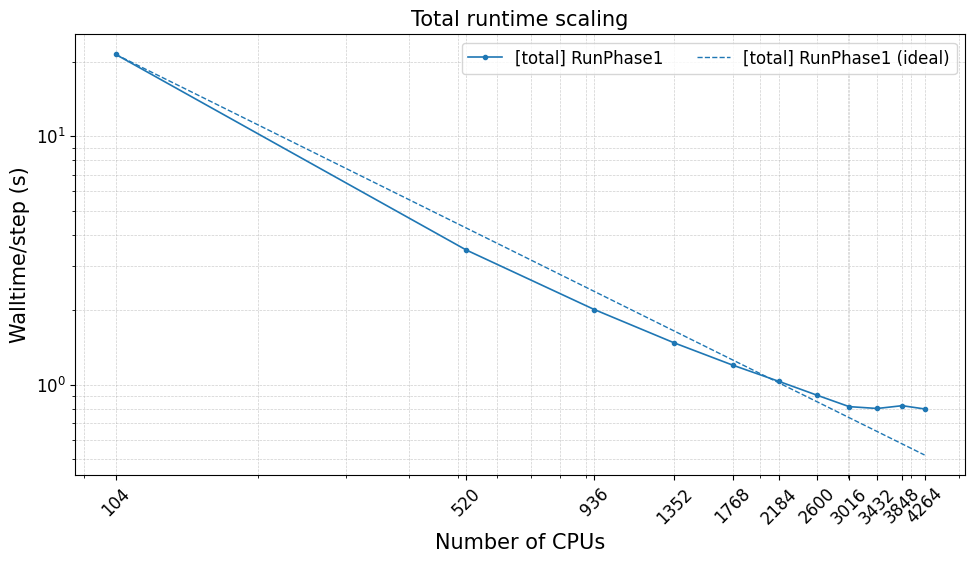

In [8]:
cores_per_component = {
    "[total] RunPhase1": [104, 520, 936, 1352, 1768, 2184, 2600, 3016, 3432, 3848, 4264],
}

new_vars = {
    "[total] RunPhase1": [
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1"
    ],
}

pivot_scaling_all_component = plot_scaling(
    stats_df=df,
    base_prefix=base_prefix,
    ycol="tmedian",
    ylabel="Walltime/step (s)",
    # ylim=(1e-4, 4e-2),
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="Total runtime scaling",
    # model_component=model_component,
    subplot_by_component=False,
    figsize=(10, 6),
    cores_per_component=cores_per_component,
    new_vars=new_vars,
)

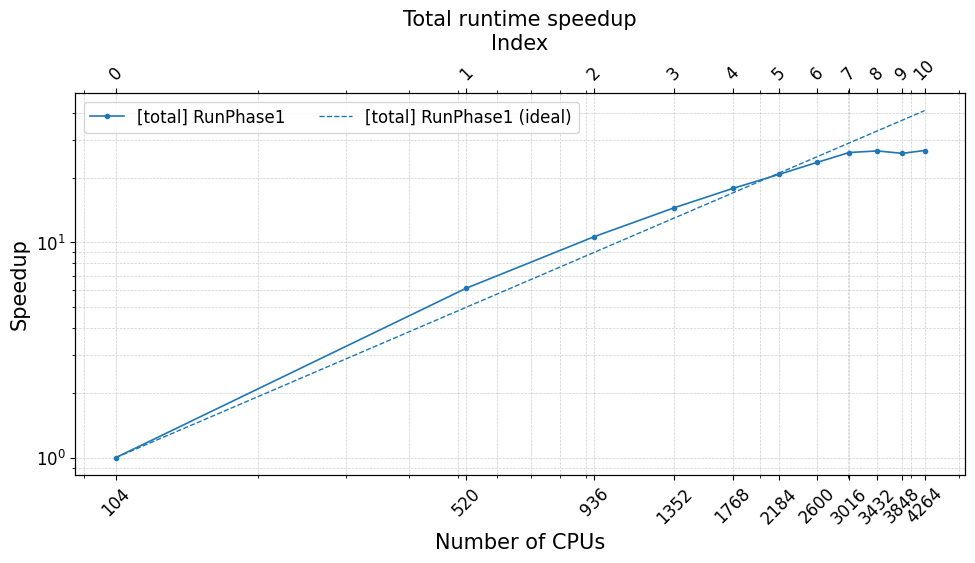

In [9]:
cores=[104, 520, 936, 1352, 1768, 2184, 2600, 3016, 3432, 3848, 4264]

pivot_speedup_data_component = plot_speedup(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    # ylim=(1e-4, 4e-2),
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="Total runtime speedup",
    # model_component=model_component,
    subplot_by_component=False,
    figsize=(10, 6),
    new_vars=new_vars,
)

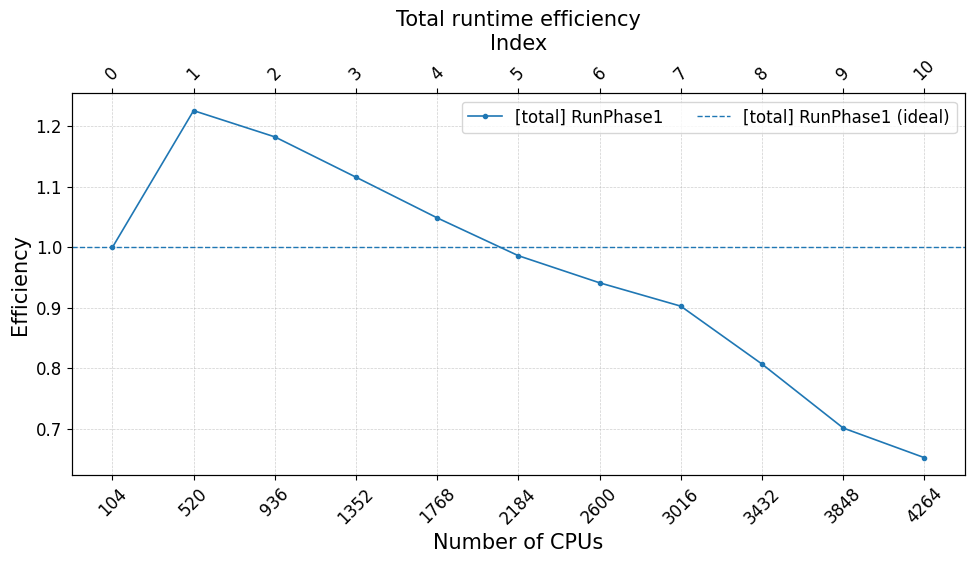

In [10]:
pivot_efficiency_data_component = plot_efficiency(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    # ylim=(1e-4, 4e-2),
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="Total runtime efficiency",
    # model_component=model_component,
    subplot_by_component=False,
    figsize=(10, 6),
    new_vars=new_vars,
)

## Generate `run-config.yaml` for the panan-4km config

In [11]:
model_component = (
    "[ESMF]/[ensemble] RunPhase1"
)

suffix = "test_all_comp"
count=11
base_prefix="panan_4km_only"
branch="panan_4km_only"
pets=['0 104', '0 520', '0 936', '0 1352', '0 1768', '0 2184', '0 2600', '0 3016', '0 3432', '0 3848', '0 4264']
list_pets = [p.replace(' ', ',') for p in pets]

list_exact_path = [f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/{base_prefix}_{i}/{branch}/archive" for i in range(1,count+1)]
post_base_path = f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/{base_prefix}_{suffix}"

run_config_med_dict = gen_run_config(
    post_base_path=post_base_path,
    model_component=model_component,
    base_prefix=base_prefix,
    count=count,
    list_pets=list_pets,
    list_exact_path=list_exact_path
)

run_config_med_path = f"/g/data/tm70/ml0072/COMMON/git_repos/esmf-trace/examples/run_config_{base_prefix}_path_{suffix}.yaml"
write_yaml(run_config_med_dict, run_config_med_path)

In [12]:
model_component = (
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ATM] RunPhase1,"
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ROF] RunPhase1,"
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_restart_write,"
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_atm, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ice, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_avg, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ocn, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_accum, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_aofluxes_run, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ice, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_rof, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ocn, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_ocnalb_run, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_ice2med, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_atm, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_med2ice, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_rof, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_accum, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_profile, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_print, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_history_write,"
    "[ESMF]/[ensemble] Init 1/[ESM0001] IPDv02p5/[MED] IPDv03p7,"
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ICE] RunPhase1,"
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1"
)

suffix = "test_all_comp"
count=11
base_prefix="panan_4km_only"
branch="panan_4km_only"
pets=['0 104', '0 520', '0 936', '0 1352', '0 1768', '0 2184', '0 2600', '0 3016', '0 3432', '0 3848', '0 4264']
list_pets = [p.replace(' ', ',') for p in pets]

list_exact_path = [f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/{base_prefix}_{i}/{branch}/archive" for i in range(1,count+1)]
post_base_path = f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/{base_prefix}_{suffix}"

run_config_med_dict = gen_run_config(
    post_base_path=post_base_path,
    model_component=model_component,
    base_prefix=base_prefix,
    count=count,
    list_pets=list_pets,
    list_exact_path=list_exact_path
)

run_config_med_path = f"/g/data/tm70/ml0072/COMMON/git_repos/esmf-trace/examples/run_config_{base_prefix}_path_{suffix}.yaml"
write_yaml(run_config_med_dict, run_config_med_path)

The above will produce a yaml file `/g/data/tm70/ml0072/COMMON/git_repos/esmf-trace/examples/run_config_panan_4km_only_path_test_all_comp.yaml`

```yaml
default_settings:
  post_base_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/panan_4km_only_test_all_comp
  model_component: '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ATM] RunPhase1,[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ROF] RunPhase1,[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_restart_write,[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_atm, [ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ice, [ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_avg, [ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ocn, [ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_accum, [ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_aofluxes_run, [ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ice, [ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_rof, [ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ocn, [ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_ocnalb_run, [ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_ice2med, [ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_atm, [ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_med2ice, [ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_rof, [ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_accum, [ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_profile, [ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_print, [ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_history_write,[ESMF]/[ensemble] Init 1/[ESM0001] IPDv02p5/[MED] IPDv03p7,[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ICE] RunPhase1,[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1'
  max_workers: 12
  stream_prefix: esmf_stream
  timeseries_suffix: _timeseries.json
runs:
  - base_prefix: panan_4km_only_1
    pets: 0,104
    exact_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/panan_4km_only_1/panan_4km_only/archive
  - base_prefix: panan_4km_only_2
    pets: 0,520
    exact_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/panan_4km_only_2/panan_4km_only/archive
  - base_prefix: panan_4km_only_3
    pets: 0,936
    exact_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/panan_4km_only_3/panan_4km_only/archive
  - base_prefix: panan_4km_only_4
    pets: 0,1352
    exact_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/panan_4km_only_4/panan_4km_only/archive
  - base_prefix: panan_4km_only_5
    pets: 0,1768
    exact_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/panan_4km_only_5/panan_4km_only/archive
  - base_prefix: panan_4km_only_6
    pets: 0,2184
    exact_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/panan_4km_only_6/panan_4km_only/archive
  - base_prefix: panan_4km_only_7
    pets: 0,2600
    exact_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/panan_4km_only_7/panan_4km_only/archive
  - base_prefix: panan_4km_only_8
    pets: 0,3016
    exact_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/panan_4km_only_8/panan_4km_only/archive
  - base_prefix: panan_4km_only_9
    pets: 0,3432
    exact_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/panan_4km_only_9/panan_4km_only/archive
  - base_prefix: panan_4km_only_10
    pets: 0,3848
    exact_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/panan_4km_only_10/panan_4km_only/archive
  - base_prefix: panan_4km_only_11
    pets: 0,4264
    exact_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/panan_4km_only_11/panan_4km_only/archive

```

## Generate `postprocessing-config.yaml` for the panan-4km config

In [13]:
post_base_path=f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/{base_prefix}_{suffix}"
save_json_path = f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/{base_prefix}_{suffix}/med_json_{suffix}.json"
model_component = [
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ATM] RunPhase1",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ROF] RunPhase1",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_restart_write",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_atm",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ice",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_avg",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ocn",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_accum",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_aofluxes_run",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ice",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_rof",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ocn",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_ocnalb_run",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_ice2med",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_atm",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_med2ice",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_rof",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_accum",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_profile",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_print",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_history_write",
    "[ESMF]/[ensemble] Init 1/[ESM0001] IPDv02p5/[MED] IPDv03p7",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ICE] RunPhase1",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1",
]
model_component = model_component

post_config_med_dict = gen_postprocessing_config(
    post_base_path=post_base_path,
    base_prefix=base_prefix,
    count=count,
    model_component=model_component,
    list_pets=list_pets,
    save_json_path=save_json_path,
    stats_start_index=0,
    stats_end_index=None,
)
post_config_med_path = f"/g/data/tm70/ml0072/COMMON/git_repos/esmf-trace/examples/post_config_{base_prefix}_path_{suffix}.yaml"
write_yaml(post_config_med_dict, post_config_med_path)

## postprocessing-config.yaml
The above will generate a yaml file `/g/data/tm70/ml0072/COMMON/git_repos/esmf-trace/examples/post_config_panan_4km_only_path_test_all_comp.yaml`

```yaml
default_settings:
  post_base_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/panan_4km_only_test_all_comp
  model_component:
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ATM] RunPhase1'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ROF] RunPhase1'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_restart_write'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_atm'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ice'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_avg'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ocn'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_accum'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_aofluxes_run'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ice'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_rof'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ocn'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_ocnalb_run'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_ice2med'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_atm'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_med2ice'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_rof'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_accum'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_profile'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_print'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_history_write'
    - '[ESMF]/[ensemble] Init 1/[ESM0001] IPDv02p5/[MED] IPDv03p7'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ICE] RunPhase1'
    - '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1'
  save_json_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/panan_4km_only_test_all_comp/med_json_test_all_comp.json
  stats_start_index: 0
  stats_end_index:
  stream_prefix: esmf_stream
  timeseries_suffix: _timeseries.json
runs:
  - name: postprocessing_panan_4km_only_1
    pets: 0,104
  - name: postprocessing_panan_4km_only_2
    pets: 0,520
  - name: postprocessing_panan_4km_only_3
    pets: 0,936
  - name: postprocessing_panan_4km_only_4
    pets: 0,1352
  - name: postprocessing_panan_4km_only_5
    pets: 0,1768
  - name: postprocessing_panan_4km_only_6
    pets: 0,2184
  - name: postprocessing_panan_4km_only_7
    pets: 0,2600
  - name: postprocessing_panan_4km_only_8
    pets: 0,3016
  - name: postprocessing_panan_4km_only_9
    pets: 0,3432
  - name: postprocessing_panan_4km_only_10
    pets: 0,3848
  - name: postprocessing_panan_4km_only_11
    pets: 0,4264

```


## .parquet file
After running `esmf-trace post-summary-from-yaml --config postprocessing-config.yaml`, a parquet file is then created and can be read through `pd.read_parquet` shown as below.

In [14]:
df = pd.read_parquet(f"{post_base_path}/med_json_{suffix}_table.parquet")

In [15]:
df

,hits,tmin,tmax,tavg,tmedian,tstd,pemin,pemax
name,,,,,,,,
postprocessing_panan_4km_only_1/output000/[ESMF]/[ensemble] Init 1/[ESM0001] IPDv02p5/[MED] IPDv03p7,2.0,0.773399,95.048981,47.911190,47.911190,66.662903,0,0
postprocessing_panan_4km_only_1/output000/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ATM] RunPhase1,288.0,0.018944,0.195784,0.038370,0.028390,0.028717,0,0
postprocessing_panan_4km_only_1/output000/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ICE] RunPhase1,288.0,2.138908,23.188956,2.434817,2.223217,1.558450,0,0
postprocessing_panan_4km_only_1/output000/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_aofluxes_run,288.0,0.017460,1.207144,0.024662,0.020223,0.069948,0,0
postprocessing_panan_4km_only_1/output000/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_accum,288.0,0.000086,0.000594,0.000131,0.000120,0.000043,0,0
...,...,...,...,...,...,...,...,...
postprocessing_panan_4km_only_11/combine/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_avg,288.0,0.002816,0.005709,0.004192,0.004189,0.000299,0,0
postprocessing_panan_4km_only_11/combine/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_profile,288.0,0.000063,0.000468,0.000073,0.000070,0.000033,0,0
postprocessing_panan_4km_only_11/combine/[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_restart_write,288.0,0.000074,96.912828,0.336587,0.000083,5.710638,0,0


## This is for all component scaling overview

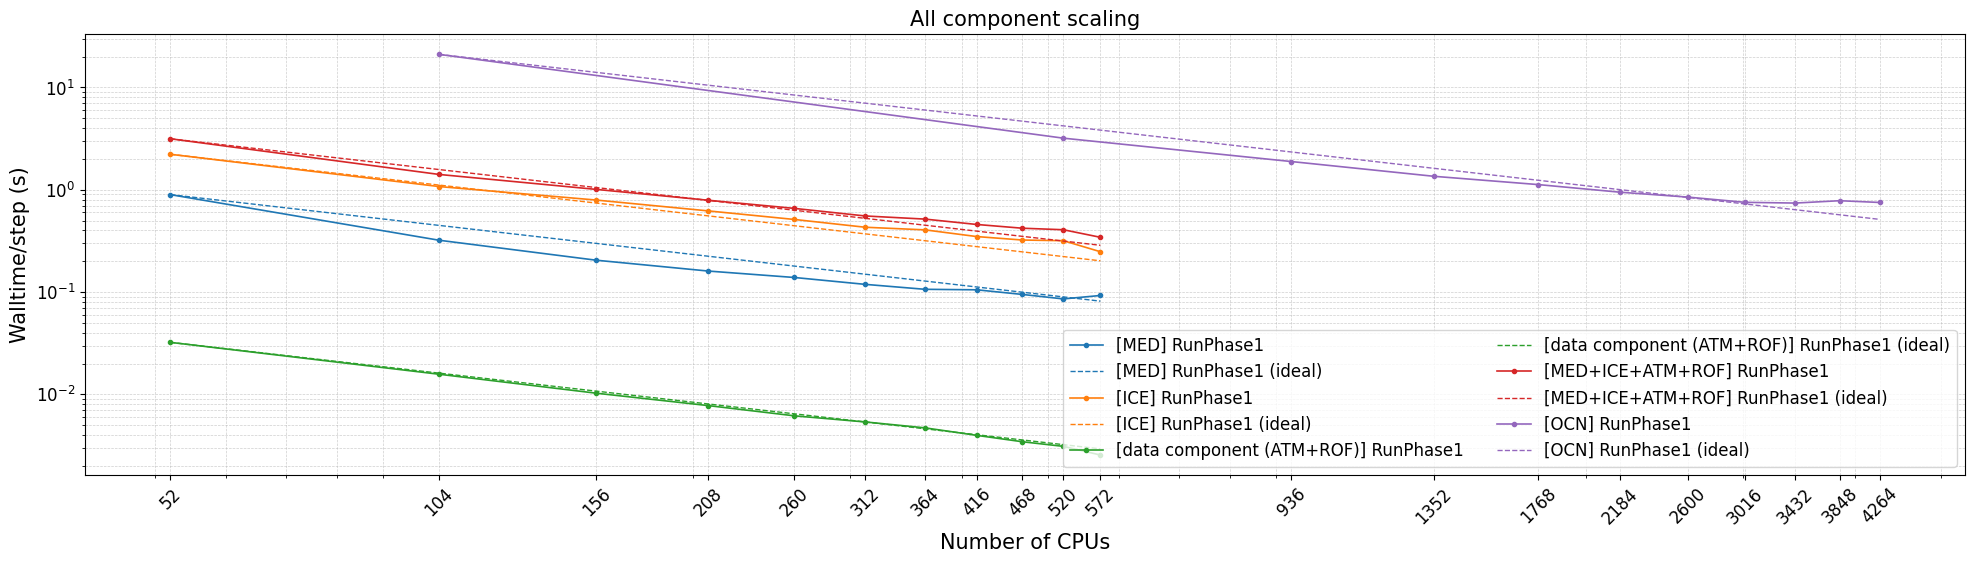

In [16]:
cores=[52, 104, 156, 208, 260, 312, 364, 416, 468, 520, 572]
cores_ocn=[104, 520, 936, 1352, 1768, 2184, 2600, 3016, 3432, 3848, 4264]

cores_per_component = {
    "[MED] RunPhase1": cores,
    "[ICE] RunPhase1": cores,
    "[data component (ATM+ROF)] RunPhase1": cores,
    "[MED+ICE+ATM+ROF] RunPhase1": cores,
    "[OCN] RunPhase1": cores_ocn,
}

new_vars = {
    "[MED] RunPhase1": [
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_atm",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ice",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_avg",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ocn",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_accum",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_aofluxes_run",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ice",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_rof",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ocn",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_ocnalb_run",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_ice2med",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_atm",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_med2ice",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_rof",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_accum",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_restart_write",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_profile",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_print",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_history_write",
    ],
    "[ICE] RunPhase1": [
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ICE] RunPhase1",
    ],
    "[data component (ATM+ROF)] RunPhase1":[
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ATM] RunPhase1",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ROF] RunPhase1",
    ],
    "[MED+ICE+ATM+ROF] RunPhase1":[
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_atm",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ice",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_avg",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ocn",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_accum",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_aofluxes_run",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ice",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_rof",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ocn",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_ocnalb_run",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_ice2med",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_atm",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_med2ice",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_rof",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_accum",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_restart_write",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_profile",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_print",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_history_write",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ICE] RunPhase1",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ATM] RunPhase1",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ROF] RunPhase1",
    ],
    "[OCN] RunPhase1": [
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1"
    ],
    
}

pivot_scaling_all_components = plot_scaling(
    stats_df=df,
    base_prefix=base_prefix,
    ycol="tmedian",
    ylabel="Walltime/step (s)",
    # ylim=(1e-4, 4e-2),
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="All component scaling",
    # model_component=model_component,
    subplot_by_component=False,
    figsize=(20, 6),
    cores_per_component=cores_per_component,
    new_vars=new_vars,
)

In [17]:
pivot_scaling_all_components

,[MED] RunPhase1,[ICE] RunPhase1,[data component (ATM+ROF)] RunPhase1,[MED+ICE+ATM+ROF] RunPhase1,[OCN] RunPhase1
__output_name,combine,combine,combine,combine,combine
cores,,,,,
52.0,0.896727,2.223217,0.032251,3.152196,NaN
104.0,0.321065,1.074912,0.015735,1.411712,21.058545
156.0,0.204744,0.792909,0.010264,1.007917,NaN
208.0,0.160558,0.621786,0.007773,0.790117,NaN
260.0,0.138787,0.512307,0.006168,0.657262,NaN
312.0,0.118921,0.430091,0.005375,0.554387,NaN
364.0,0.106393,0.405507,0.004705,0.516605,NaN
416.0,0.105189,0.348610,0.003974,0.457773,NaN


# This is for ice components

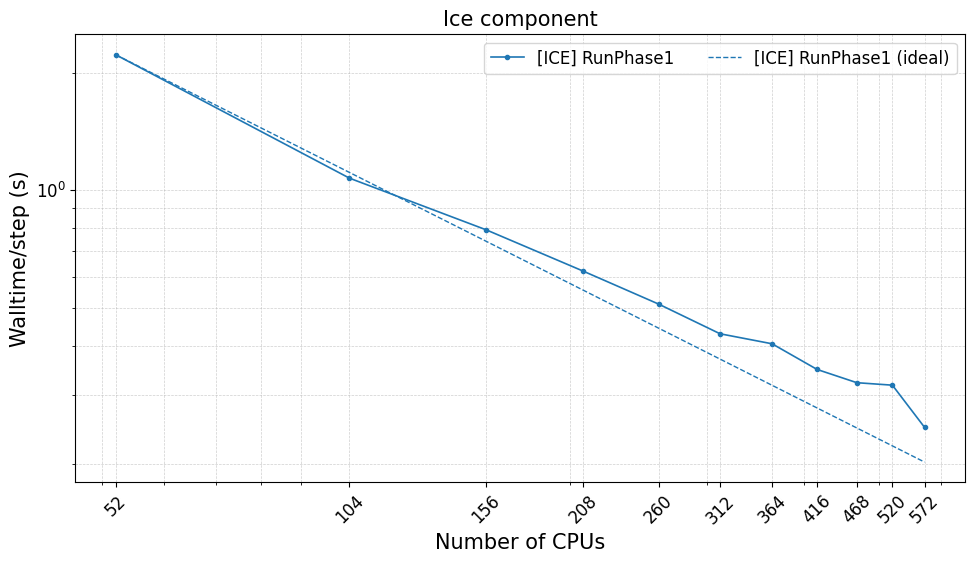

In [18]:
cores_per_component = {
    "[ICE] RunPhase1": cores,
}

model_component = (
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ICE] RunPhase1,"
)

pivot_scaling_ice = plot_scaling(
    stats_df=df,
    base_prefix=base_prefix,
    ycol="tmedian",
    ylabel="Walltime/step (s)",
    # ylim=(1e-4, 4e-2),
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="Ice component",
    model_component=model_component,
    subplot_by_component=True,
    figsize=(10, 6),
    cores_per_component=cores_per_component,
)

In [19]:
pivot_scaling_ice

,[ICE] RunPhase1
__output_name,combine
cores,
52.0,2.223217
104.0,1.074912
156.0,0.792909
208.0,0.621786
260.0,0.512307
312.0,0.430091
364.0,0.405507
416.0,0.348610


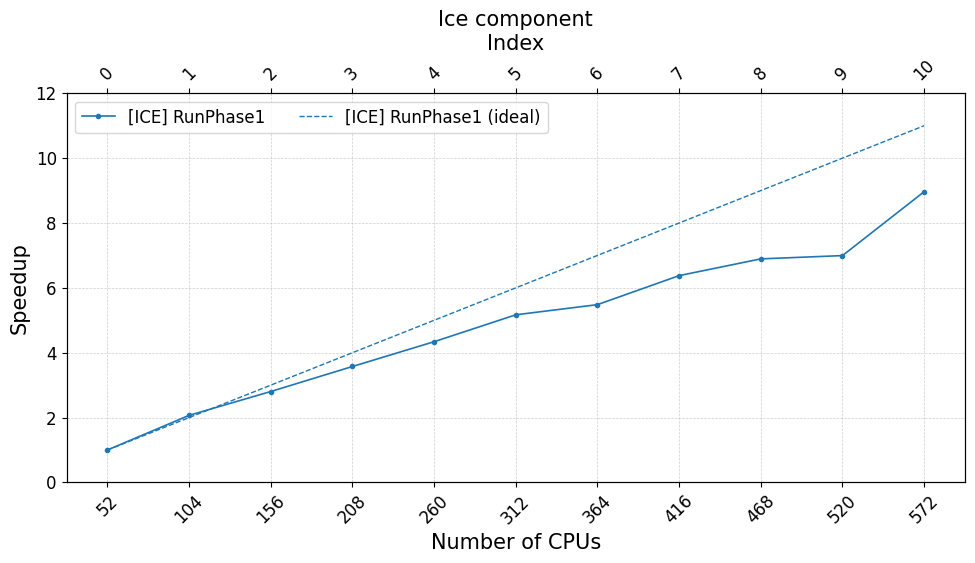

In [20]:
pivot_speedup_ice = plot_speedup(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    ylim=(0,12),
    loglog=False,
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="Ice component",
    model_component=model_component,
    subplot_by_component=True,
    figsize=(10,6)
)

In [21]:
pivot_speedup_ice

,[ICE] RunPhase1
,combine
cores,
52,1.000000
104,2.068278
156,2.803874
208,3.575534
260,4.339621
312,5.169178
364,5.482566
416,6.377377


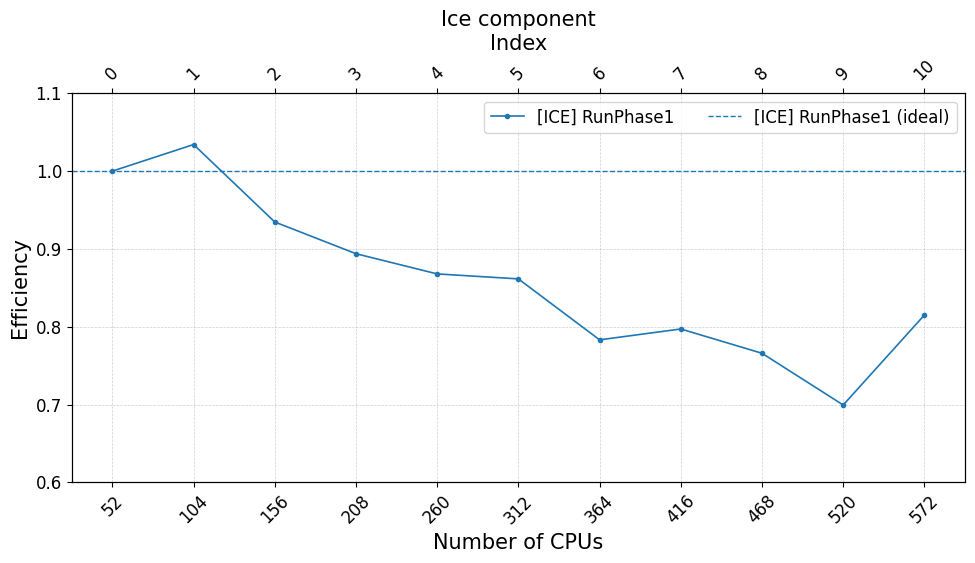

In [22]:
pivot_efficiency_ice = plot_efficiency(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    ylim=(0.6, 1.1),
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="Ice component",
    model_component=model_component,
    subplot_by_component=True,
    figsize=(10,6)
)

In [23]:
pivot_efficiency_ice

,[ICE] RunPhase1
,combine
cores,
52,1.000000
104,1.034139
156,0.934625
208,0.893884
260,0.867924
312,0.861530
364,0.783224
416,0.797172


# This is for the ocn component

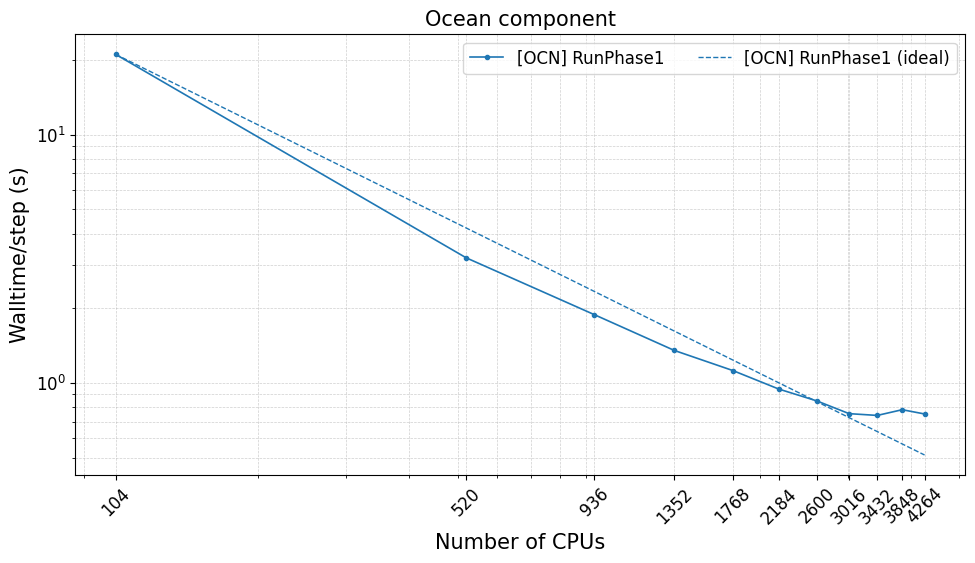

In [24]:
cores_per_component = {
    "[OCN] RunPhase1": cores_ocn,
}

model_component = (
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1"
)

pivot_scaling_ocn = plot_scaling(
    stats_df=df,
    base_prefix=base_prefix,
    ycol="tmedian",
    ylabel="Walltime/step (s)",
    # ylim=(1e-4, 4e-2),
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="Ocean component",
    model_component=model_component,
    subplot_by_component=True,
    figsize=(10, 6),
    cores_per_component=cores_per_component,
)

In [25]:
pivot_scaling_ocn

,[OCN] RunPhase1
__output_name,combine
cores,
104.0,21.058545
520.0,3.193890
936.0,1.886957
1352.0,1.353598
1768.0,1.123822
2184.0,0.946363
2600.0,0.847967
3016.0,0.753490


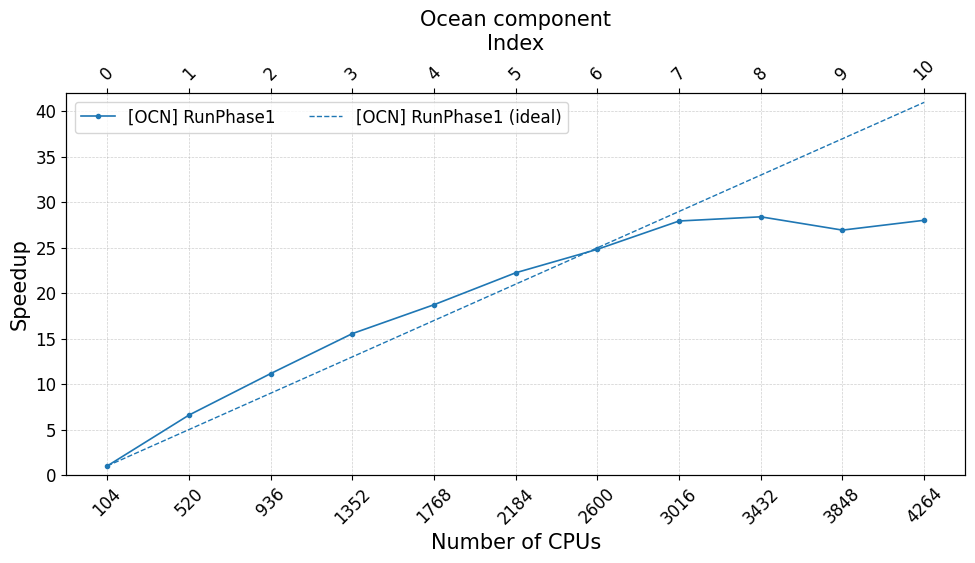

In [26]:
pivot_speedup_ocn = plot_speedup(
    stats_df=df,
    cores=cores_ocn,
    base_prefix=base_prefix,
    ycol="tmedian",
    ylim=(0, 42),
    loglog=False,
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="Ocean component",
    model_component=model_component,
    subplot_by_component=True,
    figsize=(10,6)
)

In [27]:
pivot_speedup_ocn

,[OCN] RunPhase1
,combine
cores,
104,1.000000
520,6.593385
936,11.160057
1352,15.557455
1768,18.738332
2184,22.252069
2600,24.834149
3016,27.947998


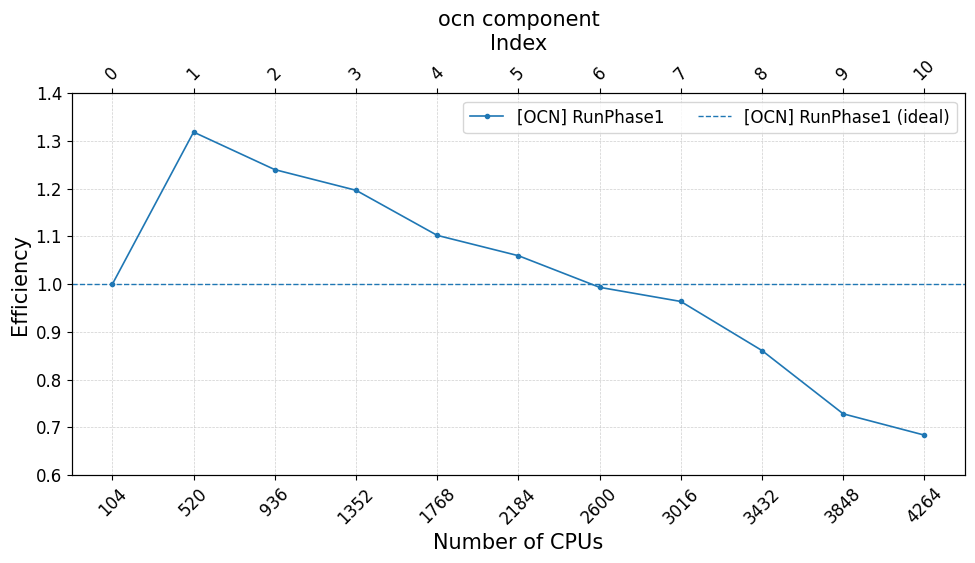

In [28]:
pivot_efficiency_ocn = plot_efficiency(
    stats_df=df,
    cores=cores_ocn,
    base_prefix=base_prefix,
    ycol="tmedian",
    ylim=(0.6, 1.4),
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="ocn component",
    model_component=model_component,
    subplot_by_component=True,
    figsize=(10,6)
)

In [29]:
pivot_efficiency_ocn

,[OCN] RunPhase1
,combine
cores,
104,1.000000
520,1.318677
936,1.240006
1352,1.196727
1768,1.102255
2184,1.059622
2600,0.993366
3016,0.963724


# This is for MED components

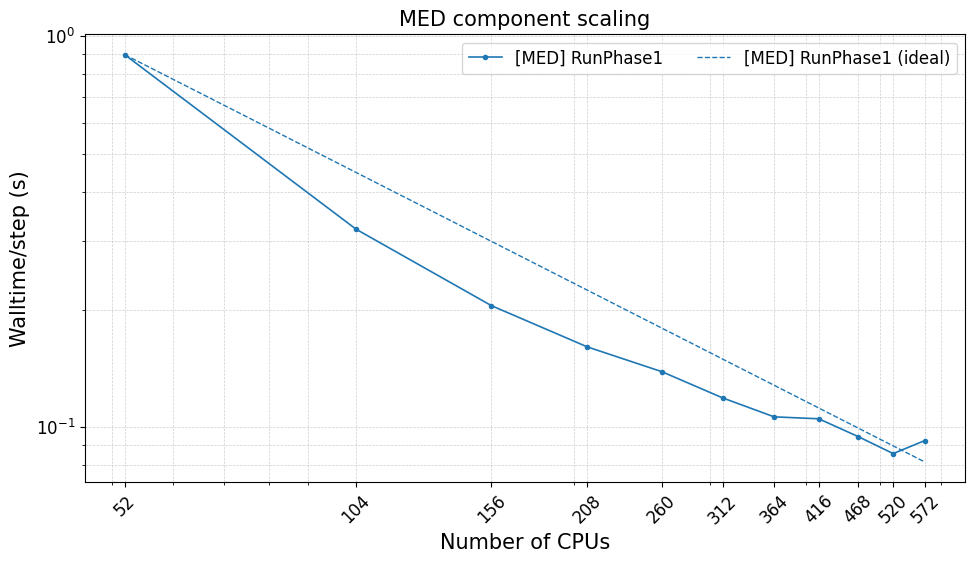

In [30]:
cores_per_component = {
    "[MED] RunPhase1": cores,
}

new_vars = {
    "[MED] RunPhase1": [
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_atm",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ice",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_avg",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ocn",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_accum",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_aofluxes_run",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ice",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_rof",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ocn",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_ocnalb_run",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_ice2med",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_atm",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_med2ice",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_rof",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_accum",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_restart_write",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_profile",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_print",
        "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_history_write",
    ],
}

pivot_scaling_med_post = plot_scaling(
    stats_df=df,
    base_prefix=base_prefix,
    ycol="tmedian",
    ylabel="Walltime/step (s)",
    # ylim=(1e-4, 4e-2),
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="MED component scaling",
    # model_component=model_component,
    subplot_by_component=False,
    figsize=(10, 6),
    cores_per_component=cores_per_component,
    new_vars=new_vars,
)

In [31]:
pivot_scaling_med_post

,[MED] RunPhase1
__output_name,combine
cores,
52.0,0.896727
104.0,0.321065
156.0,0.204744
208.0,0.160558
260.0,0.138787
312.0,0.118921
364.0,0.106393
416.0,0.105189


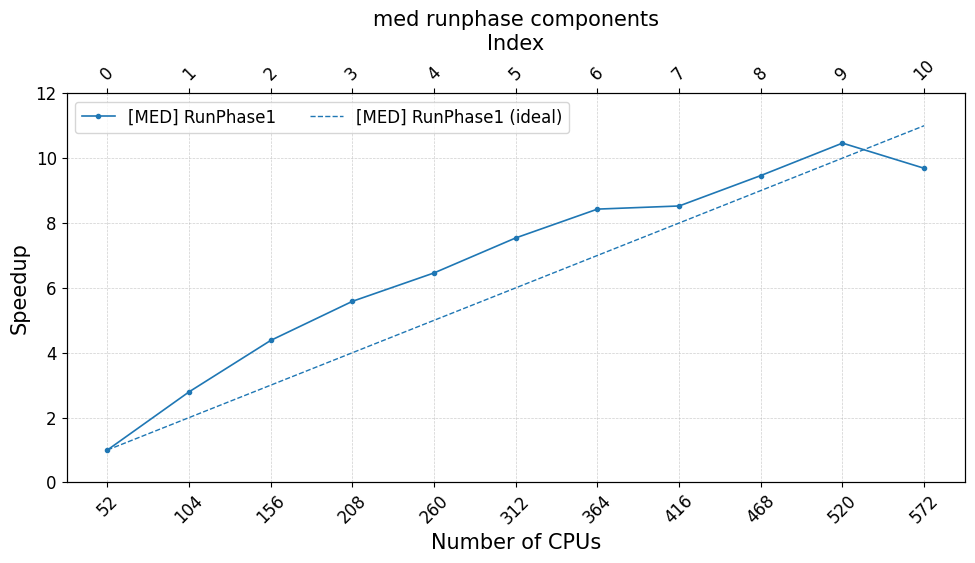

In [32]:
pivot_speedup_med_post = plot_speedup(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    ylim=(0,12),
    loglog=False,
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="med runphase components",
    #model_component=model_component,
    subplot_by_component=True,
    figsize=(10,6),
    new_vars=new_vars,
)


In [33]:
pivot_speedup_med_post

,[MED] RunPhase1
,combine
cores,
52,1.000000
104,2.792975
156,4.379747
208,5.585065
260,6.461164
312,7.540508
364,8.428458
416,8.524897


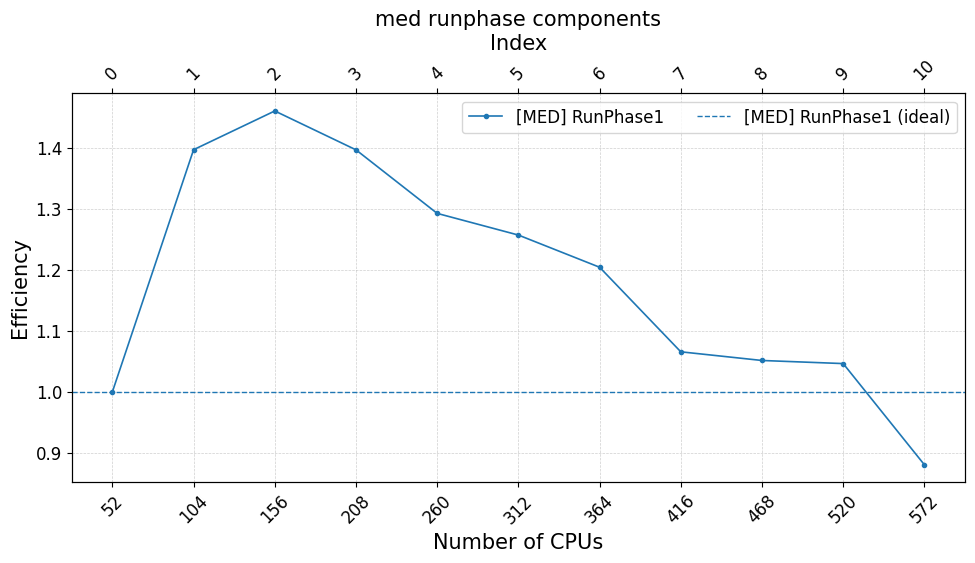

In [34]:
pivot_efficiency_med_post = plot_efficiency(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="med runphase components",
    #model_component=model_component,
    subplot_by_component=True,
    figsize=(10,6),
    new_vars=new_vars,
)


In [35]:
pivot_efficiency_med_post

,[MED] RunPhase1
,combine
cores,
52,1.000000
104,1.396488
156,1.459916
208,1.396266
260,1.292233
312,1.256751
364,1.204065
416,1.065612
